In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import utulek

import os
import pathlib
import pprint
import json
import tqdm
import dill
import matplotlib
import IPython
import typing
import numpy as np
import librosa

import transformers
import torch
import whisper

ASSETS_DIR = (
    os.getcwd() + "/experiment/" + utulek.filesystem.get_notebook_name() + ".assets/"
)
pprint.pp(ASSETS_DIR)

try:
    print(torch.cuda.is_available())
    print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
    print(torch.cuda.FloatTensor())
except:
    pass

'/home/gilgamesh/main.syncthing/utulek/experiment/2026_01_02_whisper.ipynb.assets/'
True
['NVIDIA GeForce GTX 1080 Ti']
tensor([], device='cuda:0')


In [4]:
with open(".data/2026_01_01_whisper.ipynb.dill", "rb") as dillfile:
    dilldata = dill.load(dillfile)

In [5]:
pprint.pp(dilldata.keys())
pprint.pp(dilldata["language"])
pprint.pp(dilldata["segments"][-1])
pprint.pp(dilldata["segments"][-1]["end"] / 60)

# So "start"/"end" seem to be in seconds. Can we run a text classifier on the sponsor-ness of each segment (or few consecutive segments)?

dict_keys(['text', 'segments', 'language'])
'en'
{'id': 1370,
 'seek': 298296,
 'start': 2989.54,
 'end': 2990.36,
 'text': ' Guaranteed human.',
 'tokens': [50694, 2694, 289, 2879, 292, 1952, 13, 50735],
 'temperature': 0.0,
 'avg_logprob': -0.28385277798301295,
 'compression_ratio': 1.0454545454545454,
 'no_speech_prob': 1.6234286484562155e-11}
49.839333333333336


In [6]:
SEGMENT_CONTEXT_SIZE = 16
segments = dilldata["segments"]
segment_contexts = []
for i in range(SEGMENT_CONTEXT_SIZE // 2, len(segments) - SEGMENT_CONTEXT_SIZE // 2):
    segment_context_text = ""
    for j in range(i - SEGMENT_CONTEXT_SIZE // 2, i + SEGMENT_CONTEXT_SIZE // 2):
        segment_context_text += segments[j]["text"]
    # print(segment_context_text)
    segment_contexts.append(segment_context_text)

In [7]:
segment_contexts[-8]

" No price markups when I order same day delivery from tons of local stores. Only a handful of alcohol retailers and items don't count. I won't lie. I've had too much fun being like markups on groceries? Not in my fridge. Markups on pet food? Not for my DOG. Markups on tools? Electronics? Home goods? Meds?"

In [8]:
classifier = transformers.pipeline(model="facebook/bart-large-mnli")

2026-01-02 12:03:41.185333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gilgamesh/main.syncthing/utulek/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Device set to use cuda:0


In [9]:
CANDIDATE_LABELS = ["podcast sponsor", "podcast advertisement"]

In [10]:
classifier("hello world!", candidate_labels=CANDIDATE_LABELS)

{'sequence': 'hello world!',
 'labels': ['podcast sponsor', 'podcast advertisement'],
 'scores': [0.6479831337928772, 0.3520168364048004]}

In [11]:
classifier(segment_contexts[0], candidate_labels=CANDIDATE_LABELS)

{'sequence': " This is an iHeart Podcast. Guaranteed human. Bring along an American Express card to open the door to rewards wherever you go. Morning coffee run with an old friend? Earn cash back. Weekend getaway? Earn miles. Dinner at the hottest restaurant in town? You get the idea. No matter the place or the plan, Amex rewards your inner explorer. See if you pre-qualify for an American Express card with no impact on your credit score. Learn more at americanexpress.com slash check-4-offers. Your credit score may be impacted if you accept a card. Terms apply. Run a business and not thinking about podcasting? Think again. More Americans listen to podcasts, then add supported streaming music from Spotify and Pandora. And as the number one podcaster, iHeart's twice as large as the next two combined. Learn how podcasting can help your business. Call 844-844-iHeart.",
 'labels': ['podcast sponsor', 'podcast advertisement'],
 'scores': [0.8548117280006409, 0.14518828690052032]}

In [12]:
classifier(segment_contexts[20], candidate_labels=CANDIDATE_LABELS)

{'sequence': " Even if it's natural, why should we suffer through it? Listen to Decoding Women's Health with Dr. Elizabeth Pointer on the iHeartRadio app, Apple Podcasts, or wherever you get your podcasts. Hi, I'm Dani Shapiro. We were in the car, like a rolling stone came on, and he said, there's a line in there about your mother. And I said, what? What I would do if I didn't feel like I was being accepted is choose an identity other people can't have. I knew something had happened to me in the middle of the night, but I couldn't hold on to what had happened. These are just a few of the moving and important stories on my 13th season of Family Secrets. Listen to Family Secrets on the iHeartRadio app, Apple Podcasts, or wherever you get your podcasts. Call Zone Media Hello and welcome to Better Offline. I'm your host, Ed Zitron. Better Offline. And I'd like to announce that much like Nvidia revealed in a recent leaked memo, we are also nothing like Enron. Today I'm joined by the wonderf

In [13]:
classifier(segment_contexts[100], candidate_labels=CANDIDATE_LABELS)

{'sequence': " And so in that time we were able to speak with engineers and, you know, mess around with it. So yeah, it's a SteamOS, which is on the Steam Deck. So the Steam Deck is a gaming handheld device that, these have existed for a long time, but the Deck was kind of the first one in recent years to really breathe life into the gaming handheld market outside of Nintendo. And that's not necessarily because everyone bought the Deck, but it's because all the other manufacturers saw like, oh, this is real. Like Steam is a serious venue, you know, to move games and people will buy stuff. And so Asus and Lenovo and all the other competitors jumped in. So the Steam Machine is building on that because the Steam Deck uses SteamOS, which is a, an Arch Linux based distribution. And it has a, a lot of optimizations that solve long running problems with Linux and gaming in general. So that would include, for example, translation layers and things like this. So they build on that. And then, ye

In [14]:
classifier(segment_contexts[-1], candidate_labels=CANDIDATE_LABELS)

{'sequence': " I've had too much fun being like markups on groceries? Not in my fridge. Markups on pet food? Not for my DOG. Markups on tools? Electronics? Home goods? Meds? Not in my house. Anyway, it's awesome. Order now at shipped.com slash 360 terms apply. This is an iHeart podcast.",
 'labels': ['podcast sponsor', 'podcast advertisement'],
 'scores': [0.6438190937042236, 0.356180876493454]}

In [57]:
# Seems like this classification method is not very effective. Let's try 0-shot audio classification directly.

classifier = transformers.pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)

Device set to use cuda:0


In [58]:
audio_data, audio_sr = librosa.load(ASSETS_DIR + "podcast.opus", sr=None)
audio_data, audio_sr

(array([-3.0517578e-05, -6.1035156e-05, -6.1035156e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       shape=(143584027,), dtype=float32),
 48000)

In [59]:
IPython.display.Audio(data=audio_data[: 8 * audio_sr], rate=audio_sr)

In [60]:
classification = classifier(
    audio_data[: 8 * audio_sr], candidate_labels=["podcast", "music", "advertisement"]
)
classification

[{'score': 0.9321531057357788, 'label': 'advertisement'},
 {'score': 0.06496758759021759, 'label': 'podcast'},
 {'score': 0.0028793306555598974, 'label': 'music'}]

In [61]:
classification = classifier(
    audio_data[100 * audio_sr : 108 * audio_sr],
    candidate_labels=["podcast", "music", "advertisement"],
)
classification

[{'score': 0.9324840903282166, 'label': 'advertisement'},
 {'score': 0.06186613440513611, 'label': 'podcast'},
 {'score': 0.0056498232297599316, 'label': 'music'}]

In [62]:
IPython.display.Audio(data=audio_data[100 * audio_sr : 108 * audio_sr], rate=audio_sr)

In [63]:
audio_len = len(audio_data)
audio_len

143584027

In [66]:
SEGMENT_LEN = 16
audio_padding_len = SEGMENT_LEN * audio_sr - audio_len % (SEGMENT_LEN * audio_sr)
print(audio_padding_len)
audio_data_padded = np.hstack([audio_data, np.zeros((audio_padding_len,))])
pprint.pp(audio_data_padded)

31973
array([-3.05175781e-05, -6.10351562e-05, -6.10351562e-05, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
      shape=(143616000,))


In [68]:
audio_segments = []
for i in range(0, len(audio_data_padded) - (SEGMENT_LEN - 1) * audio_sr, audio_sr):
    audio_segments.append(audio_data_padded[i : i + SEGMENT_LEN * audio_sr])
print(len(audio_segments), audio_segments[-1])
IPython.display.Audio(data=audio_segments[-1], rate=audio_sr)

2977 [0.07067871 0.06936646 0.06698608 ... 0.         0.         0.        ]


In [69]:
segment_classifications = []
for i in tqdm.tqdm(range(len(audio_segments))):
    segment_classifications.append(
        classifier(
            audio_segments[i],
            candidate_labels=[
                "advertisement",
                "sponsor",
                "advertisement or sponsor",
                "podcast advertisement",
            ],
        )
    )
segment_classifications[0:8]

100%|██████████| 2977/2977 [03:42<00:00, 13.39it/s]


[[{'score': 0.475839227437973, 'label': 'advertisement'},
  {'score': 0.44144967198371887, 'label': 'podcast advertisement'},
  {'score': 0.08139462023973465, 'label': 'advertisement or sponsor'},
  {'score': 0.0013164578704163432, 'label': 'sponsor'}],
 [{'score': 0.5081958174705505, 'label': 'podcast advertisement'},
  {'score': 0.4396218955516815, 'label': 'advertisement'},
  {'score': 0.05031409487128258, 'label': 'advertisement or sponsor'},
  {'score': 0.0018682092195376754, 'label': 'sponsor'}],
 [{'score': 0.4987986981868744, 'label': 'podcast advertisement'},
  {'score': 0.4443605840206146, 'label': 'advertisement'},
  {'score': 0.05489850044250488, 'label': 'advertisement or sponsor'},
  {'score': 0.001942176604643464, 'label': 'sponsor'}],
 [{'score': 0.4868882894515991, 'label': 'podcast advertisement'},
  {'score': 0.4496457874774933, 'label': 'advertisement'},
  {'score': 0.061622217297554016, 'label': 'advertisement or sponsor'},
  {'score': 0.0018437750404700637, 'label

In [70]:
segment_scores = {}
for i in range(len(segment_classifications)):
    for j in segment_classifications[i]:
        if j["label"] not in segment_scores:
            segment_scores[j["label"]] = []
        segment_scores[j["label"]].append(j["score"])

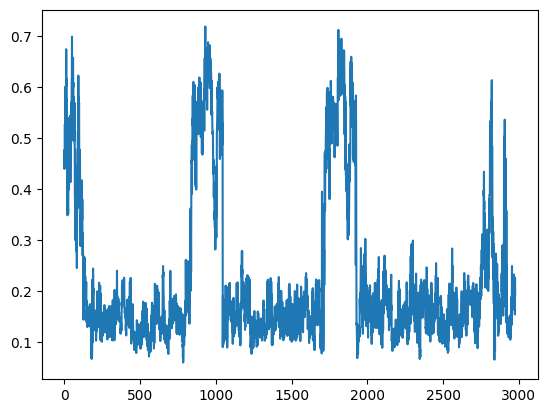

In [71]:
matplotlib.pyplot.plot(segment_scores["advertisement"])

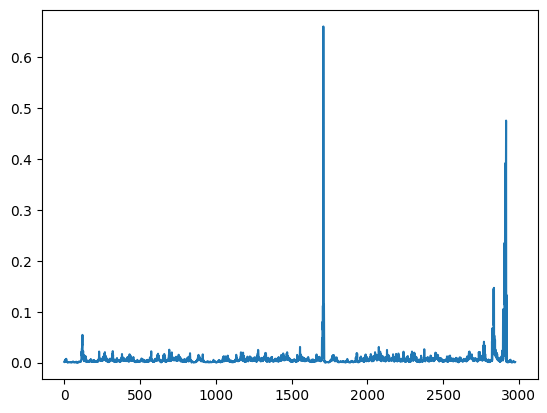

In [72]:
matplotlib.pyplot.plot(segment_scores["sponsor"])

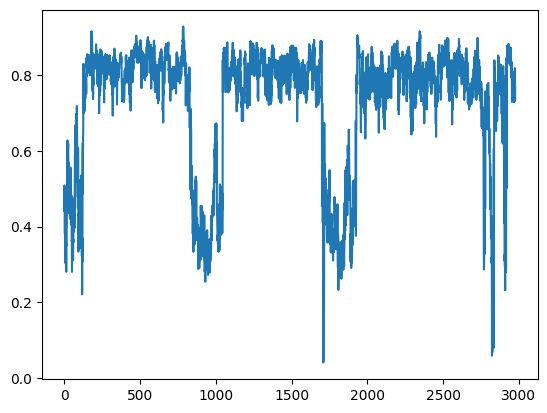

In [73]:
matplotlib.pyplot.plot(segment_scores["podcast advertisement"])

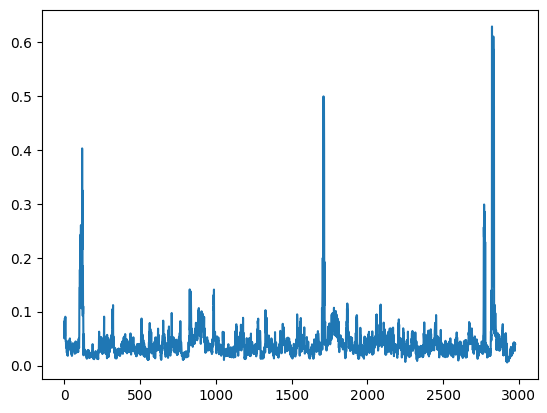

In [74]:
matplotlib.pyplot.plot(segment_scores["advertisement or sponsor"])

In [47]:
IPython.display.Audio(audio_segments[1750], rate=audio_sr)

Device set to use cuda:0
100%|██████████| 1489/1489 [01:34<00:00, 15.73it/s]


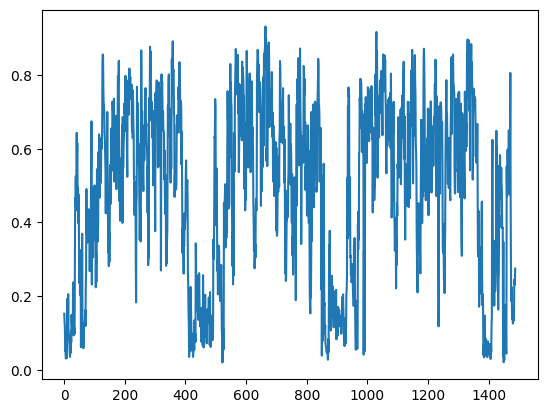

In [101]:
def score_audio_segments(
    audio_path: str,
    candidate_labels: typing.List[str],
    context_len_ms: int = 16000,
    segment_overlap_ms: int = 2000,
):
    classifier = transformers.pipeline(
        task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
    )
    audio, sr = librosa.load(audio_path, sr=None)
    audio_padded = np.hstack(
        [audio, np.zeros((segment_overlap_ms - len(audio) % segment_overlap_ms,))]
    )
    segments = [
        audio_padded[i : i + context_len_ms * sr // 1000]
        for i in range(
            0,
            len(audio_padded) - (context_len_ms - segment_overlap_ms) * sr // 1000,
            segment_overlap_ms * sr // 1000,
        )
    ]
    scores = {i: [] for i in candidate_labels}
    for i in tqdm.tqdm(range(len(segments))):
        result = classifier(segments[i], candidate_labels=candidate_labels)
        for j in result:
            scores[j["label"]].append(j["score"])

    return scores


scores = score_audio_segments(
    ASSETS_DIR + "podcast.0.opus",
    ["advertisement read or sponsor segment", "ad-free podcast"],
)
matplotlib.pyplot.plot(scores["ad-free podcast"])

Device set to use cuda:0
100%|██████████| 1489/1489 [01:57<00:00, 12.71it/s]


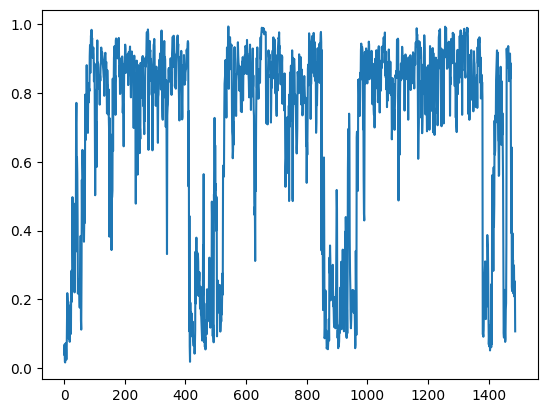

In [102]:
scores = score_audio_segments(
    ASSETS_DIR + "podcast.0.opus",
    ["advertisement", "podcast"],
)
matplotlib.pyplot.plot(scores["podcast"])

Device set to use cuda:0
100%|██████████| 2977/2977 [03:20<00:00, 14.88it/s]


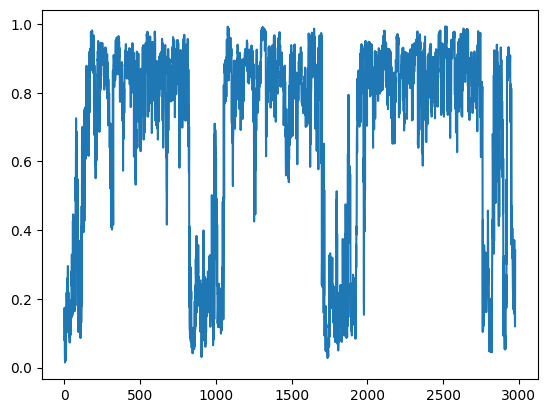

In [103]:
scores = score_audio_segments(
    ASSETS_DIR + "podcast.0.opus", ["advertisement", "podcast"], 16000, 1000
)
matplotlib.pyplot.plot(scores["podcast"])

Device set to use cuda:0
100%|██████████| 1481/1481 [01:37<00:00, 15.23it/s]


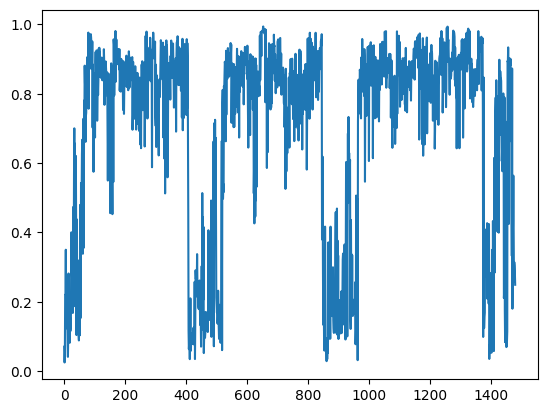

In [104]:
scores = score_audio_segments(
    ASSETS_DIR + "podcast.0.opus", ["advertisement", "podcast"], 32000, 2000
)
matplotlib.pyplot.plot(scores["podcast"])

Device set to use cuda:0
100%|██████████| 5888/5888 [06:50<00:00, 14.36it/s]


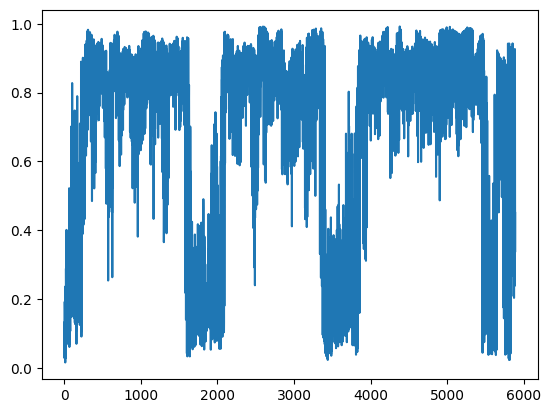

In [ ]:
scores = score_audio_segments(
    ASSETS_DIR + "podcast.0.opus", ["advertisement", "podcast"], 48000, 500
)
matplotlib.pyplot.plot(scores["podcast"])

# Seems like the model is mostly "stable", i.e. I can stretch out the overlap if necessary.

In [171]:
SEGMENT_OVERLAP_MS = 4000

Device set to use cuda:0
100%|██████████| 745/745 [00:49<00:00, 15.16it/s]


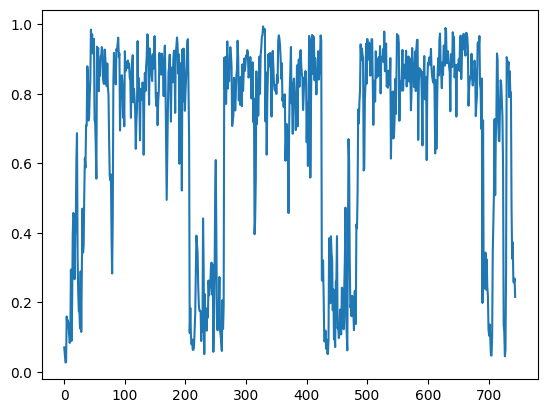

In [ ]:
scores = score_audio_segments(
    ASSETS_DIR + "podcast.0.opus",
    ["advertisement", "podcast"],
    16000,
    SEGMENT_OVERLAP_MS,
)
matplotlib.pyplot.plot(scores["podcast"])

Threshold: 0.4729185700416565


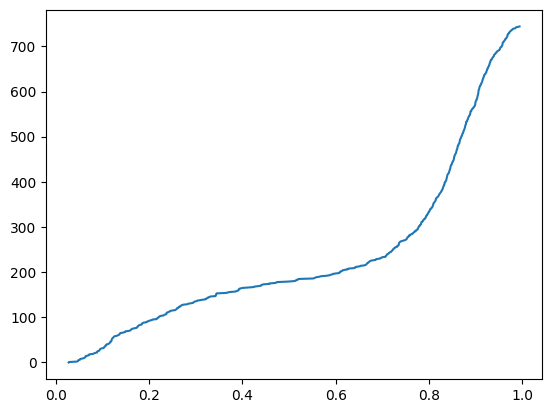

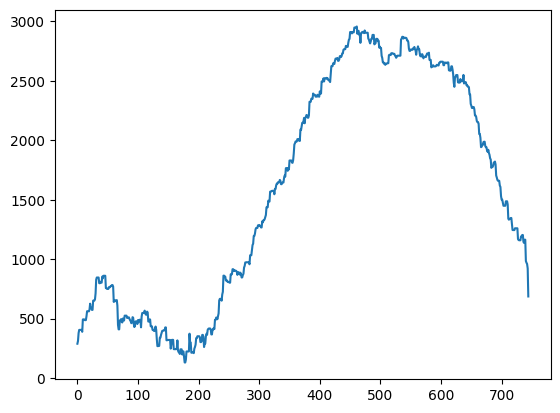

In [ ]:
# We can compute threshold directly via CDF?
p_keep = scores["podcast"]
p_keep_sorted = sorted(p_keep)
fig, ax = matplotlib.pyplot.subplots()
ax.plot(p_keep_sorted, range(len(p_keep)))

# Take the lowest slope in a reasonable range.
SLOPE_X_EPS = 0.05
slopes = [None] * len(p_keep)
for i in range(len(p_keep)):
    est_begin = est_end = i
    while (
        est_begin >= 0
        and p_keep_sorted[est_begin] + SLOPE_X_EPS / 2 >= p_keep_sorted[i]
    ):
        est_begin -= 1
    while (
        est_end < len(p_keep)
        and p_keep_sorted[est_end] - SLOPE_X_EPS / 2 <= p_keep_sorted[i]
    ):
        est_end += 1
    est_begin += 1
    est_end -= 1
    slopes[i] = (est_end - est_begin) / (
        p_keep_sorted[est_end] - p_keep_sorted[est_begin]
    )
fig, ax = matplotlib.pyplot.subplots()
ax.plot(slopes)

SLOPE_IGNORE_BOUNDARY_PERCENTILE = 0.1
threshold_i = np.argmin(
    slopes[
        int(len(slopes) * SLOPE_IGNORE_BOUNDARY_PERCENTILE) : -int(
            len(slopes) * SLOPE_IGNORE_BOUNDARY_PERCENTILE
        )
    ]
)
threshold = p_keep_sorted[
    int(len(slopes) * SLOPE_IGNORE_BOUNDARY_PERCENTILE) + threshold_i
]
print("Threshold:", threshold)

matplotlib.pyplot.show()

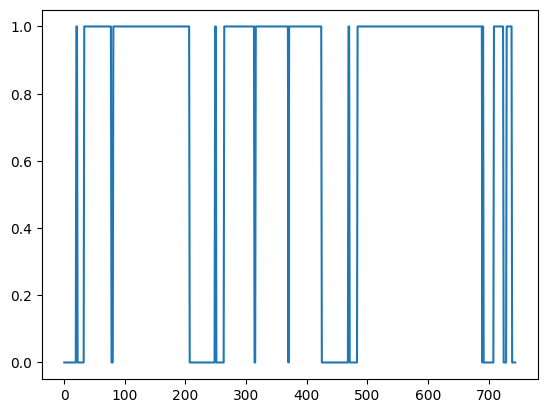

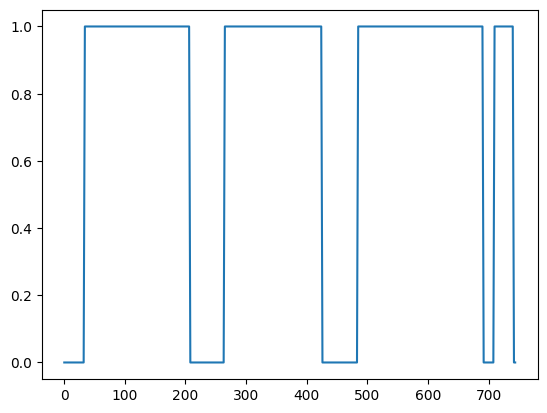

In [ ]:
raw_keep = np.asarray(p_keep) > threshold
fig, ax = matplotlib.pyplot.subplots()
ax.plot(raw_keep)

CONTEXT_RANGE = 8
median_keep = [
    np.median(raw_keep[max(0, i - CONTEXT_RANGE) : i + CONTEXT_RANGE])
    for i in range(len(raw_keep))
]
matplotlib.pyplot.subplots()[1].plot(median_keep)

In [167]:
median_keep = np.asarray(median_keep)
cut_segs = np.hstack([-1, np.where(median_keep == 0)[0], len(median_keep)])
keep_segs = np.hstack([-1, np.where(median_keep != 0)[0], len(median_keep)])
pprint.pp([cut_segs, keep_segs])
keep_breaks = np.where(keep_segs + 1 != np.roll(keep_segs, -1))[0][:-1]
cuts = keep_segs[keep_breaks] + 1, keep_segs[keep_breaks + 1]
cut_breaks = np.where(cut_segs + 1 != np.roll(cut_segs, -1))[0][:-1]
keeps = cut_segs[cut_breaks] + 1, cut_segs[cut_breaks + 1]
(cuts, keeps)

[array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 692, 693, 694, 695, 696, 697, 698, 699,
       700, 701, 702, 703, 704, 705, 706, 707, 708, 742, 743, 744, 745]),
 array([ -1,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42

((array([  0, 208, 426, 692, 742]), array([ 33, 264, 484, 709, 745])),
 (array([ 33, 264, 484, 709]), array([208, 426, 692, 742])))